# MNIST with Pytorch

## Steps to do data training, validating, and testing

### 1. Import libraries

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

### 2. Load training and validating dataset

In [2]:
train_path="./sampled_train"
batch_size=64
split_ratio=0.9
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.131, 0.131, 0.131], std=[0.290, 0.290, 0.290])
])
dataset = ImageFolder(root=train_path, transform=transform)
train_size = int(split_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### 3. Load ResNet model

In [3]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting for 10 classes

### 4. Train and validate model

In [4]:
epochs=100
lr=0.001
patience=5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    train_avg_loss = total_loss / len(train_loader)
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    val_total_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_total_loss / len(val_loader)
    val_acc = val_correct / val_total * 100
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{epochs} | LR: {current_lr:.6f} | "
            f"Train Loss: {train_avg_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model and handle early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_resnet50_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    scheduler.step(val_loss)
    
# Save final model
torch.save(model.state_dict(), 'final_resnet50_model.pth')

Epoch 1/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1/100 | LR: 0.001000 | Train Loss: 0.1095 | Train Acc: 96.68% | Val Loss: 0.0807 | Val Acc: 97.64%


Epoch 2/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2/100 | LR: 0.001000 | Train Loss: 0.0546 | Train Acc: 98.34% | Val Loss: 0.0398 | Val Acc: 98.50%


Epoch 3/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3/100 | LR: 0.001000 | Train Loss: 0.0424 | Train Acc: 98.66% | Val Loss: 0.0546 | Val Acc: 98.44%


Epoch 4/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4/100 | LR: 0.001000 | Train Loss: 0.0386 | Train Acc: 98.89% | Val Loss: 0.0671 | Val Acc: 98.16%


Epoch 5/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5/100 | LR: 0.001000 | Train Loss: 0.0366 | Train Acc: 98.85% | Val Loss: 0.0364 | Val Acc: 98.92%


Epoch 6/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6/100 | LR: 0.001000 | Train Loss: 0.0302 | Train Acc: 99.08% | Val Loss: 0.0317 | Val Acc: 99.04%


Epoch 7/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 7/100 | LR: 0.001000 | Train Loss: 0.0256 | Train Acc: 99.24% | Val Loss: 0.0415 | Val Acc: 98.90%


Epoch 8/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 8/100 | LR: 0.001000 | Train Loss: 0.0227 | Train Acc: 99.29% | Val Loss: 0.0442 | Val Acc: 98.82%


Epoch 9/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 9/100 | LR: 0.001000 | Train Loss: 0.0197 | Train Acc: 99.36% | Val Loss: 0.0372 | Val Acc: 98.84%


Epoch 10/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 10/100 | LR: 0.001000 | Train Loss: 0.0211 | Train Acc: 99.36% | Val Loss: 0.0310 | Val Acc: 99.04%


Epoch 11/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 11/100 | LR: 0.001000 | Train Loss: 0.0208 | Train Acc: 99.35% | Val Loss: 0.0293 | Val Acc: 99.08%


Epoch 12/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 12/100 | LR: 0.001000 | Train Loss: 0.0133 | Train Acc: 99.57% | Val Loss: 0.0468 | Val Acc: 98.56%


Epoch 13/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 13/100 | LR: 0.001000 | Train Loss: 0.0137 | Train Acc: 99.60% | Val Loss: 0.0481 | Val Acc: 98.88%


Epoch 14/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 14/100 | LR: 0.001000 | Train Loss: 0.0148 | Train Acc: 99.51% | Val Loss: 0.0239 | Val Acc: 99.38%


Epoch 15/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 15/100 | LR: 0.001000 | Train Loss: 0.0110 | Train Acc: 99.66% | Val Loss: 0.0302 | Val Acc: 99.12%


Epoch 16/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 16/100 | LR: 0.001000 | Train Loss: 0.0113 | Train Acc: 99.62% | Val Loss: 0.0358 | Val Acc: 99.16%


Epoch 17/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 17/100 | LR: 0.001000 | Train Loss: 0.0103 | Train Acc: 99.66% | Val Loss: 0.0326 | Val Acc: 99.10%


Epoch 18/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 18/100 | LR: 0.001000 | Train Loss: 0.0079 | Train Acc: 99.71% | Val Loss: 0.0400 | Val Acc: 98.88%


Epoch 19/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 19/100 | LR: 0.000100 | Train Loss: 0.0048 | Train Acc: 99.84% | Val Loss: 0.0213 | Val Acc: 99.40%


Epoch 20/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 20/100 | LR: 0.000100 | Train Loss: 0.0013 | Train Acc: 99.97% | Val Loss: 0.0186 | Val Acc: 99.48%


Epoch 21/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 21/100 | LR: 0.000100 | Train Loss: 0.0009 | Train Acc: 99.99% | Val Loss: 0.0182 | Val Acc: 99.58%


Epoch 22/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 22/100 | LR: 0.000100 | Train Loss: 0.0007 | Train Acc: 99.99% | Val Loss: 0.0186 | Val Acc: 99.48%


Epoch 23/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 23/100 | LR: 0.000100 | Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.0199 | Val Acc: 99.48%


Epoch 24/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 24/100 | LR: 0.000100 | Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.0203 | Val Acc: 99.46%


Epoch 25/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 25/100 | LR: 0.000100 | Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.0204 | Val Acc: 99.48%


Epoch 26/100:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 26/100 | LR: 0.000010 | Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.0205 | Val Acc: 99.48%
Early stopping triggered after 26 epochs!


### 5. Load test dataset

In [12]:
test_path="./sampled_test"
batch_size=64
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for ResNet
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.133, 0.133, 0.133], std=[0.292, 0.292, 0.292])  # Normalize for 3 channels
])
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 6. Load saved training model

In [13]:
model.load_state_dict(torch.load('final_resnet50_model.pth', weights_only=True))

<All keys matched successfully>

### 7. Evaluate on test data

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true, y_pred = [], []
progress_bar = tqdm(test_loader, desc="Evaluating", leave=True)

with torch.no_grad():
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

### 8. Compute, print, and save confusion matrix

[[500   0   0   0   0   0   0   0   0   0]
 [  0 499   1   0   0   0   0   0   0   0]
 [  0   0 499   0   0   0   0   1   0   0]
 [  0   0   1 496   0   2   0   0   0   1]
 [  0   0   0   0 500   0   0   0   0   0]
 [  0   0   0   2   0 497   1   0   0   0]
 [  1   2   1   0   1   1 493   0   1   0]
 [  0   2   1   0   0   0   0 497   0   0]
 [  1   0   1   0   0   0   0   0 498   0]
 [  0   0   0   0   1   0   0   3   0 496]]
Confusion matrix saved as 'confusion_matrix.png'


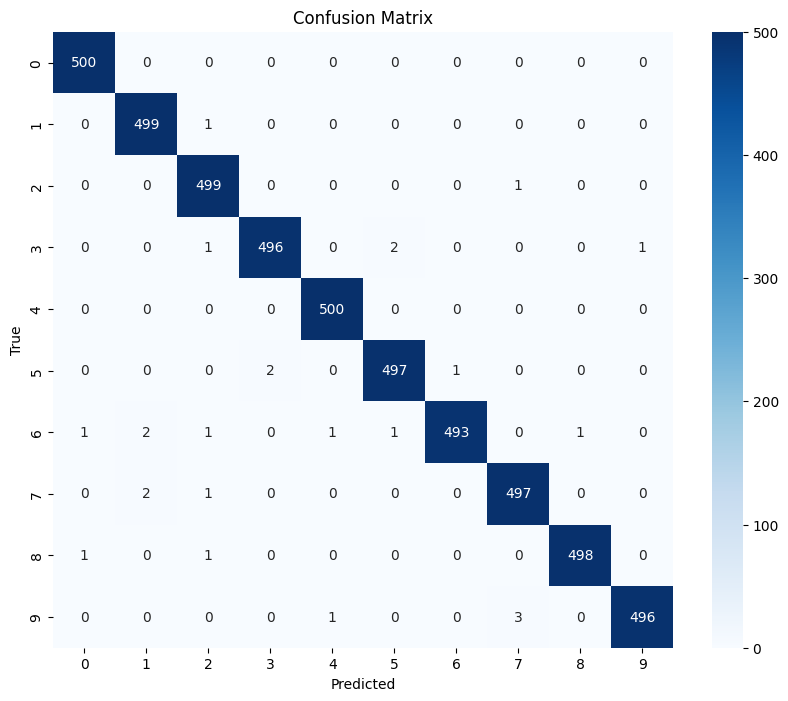

In [24]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")

print(cm)

print("Confusion matrix saved as 'confusion_matrix.png'")

### 9. Compute, print, and save classification report

In [25]:
report = classification_report(y_true, y_pred, target_names=test_dataset.classes, output_dict=True)
with open("classification_report.json", "w") as f:
    json.dump(report, f, indent=4)

print (report)
    
print("Classification report saved as 'classification_report.json'")

{'0': {'precision': 0.9960159362549801, 'recall': 1.0, 'f1-score': 0.998003992015968, 'support': 500.0}, '1': {'precision': 0.9920477137176938, 'recall': 0.998, 'f1-score': 0.9950149551345963, 'support': 500.0}, '2': {'precision': 0.9900793650793651, 'recall': 0.998, 'f1-score': 0.9940239043824701, 'support': 500.0}, '3': {'precision': 0.9959839357429718, 'recall': 0.992, 'f1-score': 0.9939879759519038, 'support': 500.0}, '4': {'precision': 0.9960159362549801, 'recall': 1.0, 'f1-score': 0.998003992015968, 'support': 500.0}, '5': {'precision': 0.994, 'recall': 0.994, 'f1-score': 0.994, 'support': 500.0}, '6': {'precision': 0.9979757085020243, 'recall': 0.986, 'f1-score': 0.9919517102615694, 'support': 500.0}, '7': {'precision': 0.9920159680638723, 'recall': 0.994, 'f1-score': 0.993006993006993, 'support': 500.0}, '8': {'precision': 0.9979959919839679, 'recall': 0.996, 'f1-score': 0.996996996996997, 'support': 500.0}, '9': {'precision': 0.9979879275653923, 'recall': 0.992, 'f1-score': 0.

### 

### 

### 

### 